# <center>  Анализ данных в задаче кредитного скоринга

По данным о кредитных историях клиентов одного из банков, следует проанализировать и сравнить показатели в двух группах, тех кто вернул кредит и тех кто не вернул кредит. Полезность данной процедуры заключается в том, что определив факторы, которые различаются статистически в двух группах, в дальнейшем будет проще идентифицировать клиента, который не вернет кредит. Например нам стали известны данные показатели после анализа, можно их включить в модель, которая предсказывает вероятность возврата кредита, тем самым увеличив качество модели.

## Описание данных

**LIMIT_BAL**:  размер кредитного лимита (в том числе и на семью клиента)

**SEX**: пол клиента (1 = мужской, 2 = женский )

**EDUCATION**: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).

**MARRIAGE**: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных). 

**AGE**: возраст в годах

**PAY_0 - PAY_6**: История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)

**BILL_AMT1 - BILL_AMT6**:  задолженность,  BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь 

**PAY_AMT1 - PAY_AMT6**: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре 

**default** - индикатор невозврата денежных средст

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportion_confint
import scipy
from scipy import stats
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('data/credit_card_default_analysis.csv')

In [3]:
data.head(2)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1


In [4]:
data.shape

(30000, 25)

## <center> Кредитный лимит
### Проверим гипотезы:
* О равенстве медианных значений кредитного лимита в двух группах
* О равенстве распределений в двух группах                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

### Проверка гипотезы  о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки

In [5]:
limit_def = data[data['default'] == 1].LIMIT_BAL.values
limit_norm = data[data['default'] == 0].LIMIT_BAL.values

In [6]:
print( "Медиана LIMIT_BAL for def = 1, =", np.median(limit_def), "\n")
print("Медиана LIMIT_BAL for def = 0, =", np.median(limit_norm))

Медиана LIMIT_BAL for def = 1, = 90000.0 

Медиана LIMIT_BAL for def = 0, = 150000.0


Точечные оценки сильно отличаются, но однозначного вывода на данном этапе делать нельзя

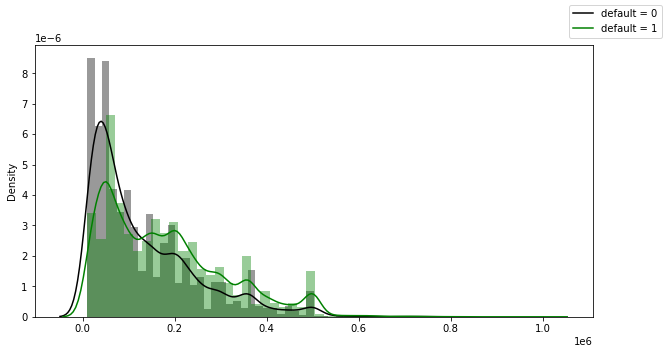

In [7]:
fig = plt.figure(1, figsize = (10,5))
sns.distplot(limit_def, norm_hist = True, color = 'black')
sns.distplot(limit_norm, norm_hist = True, color = 'green')
fig.legend(labels=['default = 0','default = 1'])

Как мы видим распределения немного отличаются. Пик приходится примерно на одно и то же значение, но распределение тех кто вернул кредит, имеет более тяжелый хвост, соответсвенно медианное значение тех кто вернул кредит находится больше чем медианное значение тех кто не вернул, но однозначно утрвеждать нельзя, что отличия статистически значимы.

Нам неизвестны истинные распределения LIMIT_BALL для тех кто вернул / не вернул кредит. Следовательно можно использовать бустреп подход, сгенерируем 10000 выборок для обоих групп используя подход бутстреп и подсчитаем медиану

In [8]:
def get_bootstrap_samples(data, n_samples):
    indexes = np.random.randint(0,len(data),(n_samples, len(data)))
    samples = data[indexes]
    return samples

In [9]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [10]:
# медианы для сгенерированных выборок
limit_def_medians = np.array(list(map(np.median,get_bootstrap_samples(limit_def, 10000))))
limit_norm_medians = np.array(list(map(np.median,get_bootstrap_samples(limit_norm, 10000))))

In [11]:
# Сравним точечные оценки для медиан
print("Точечная оценка медианы для тех кто не вернул кредит = ",limit_def_medians.mean())
print("Точечная оценка медианы для тех кто вернул кредит = ",limit_norm_medians.mean())

Точечная оценка медианы для тех кто не вернул кредит =  89732.5
Точечная оценка медианы для тех кто вернул кредит =  150031.5


**Нулевая гипотеза**: Разница медиан равна нулю

**Альтернативная гипотеза**: Разница медиан не равна нулю

In [12]:
# 95 процентный доверительный интервал для разности медиан
boundaries = stat_intervals(limit_def_medians - limit_norm_medians, 0.05)
print(boundaries)

[-70000. -60000.]


**Как мы видим, интервал не включает 0, соответственно медианные значения LIMIT_BAL для тех кто вернул и не верну кредит статистически различются**

### Проверка гипотезы о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. 

Для того, чтобы проверить гипотезу о равенстве средних следует использовать перестановочный критерий для независимых выборок

**Нулевая гипотеза**: Распределение суммы кредитного лимита для тех кто вернул кредит не отличается от распределения суммы кредитного лимита для тех кто не вернул кредит

$F_{X_1}(x) = F_{X_2}(x)$

**Альтернативная гипотеза**: Распределения одинаковы при наличии сдвига у одного из распределений

$F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [13]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [14]:
def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [15]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

In [16]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [17]:
print('p-value: %f' % permutation_test(limit_def,limit_norm, max_permutations=2000))

p-value: 0.000500


**p-value намного меньше уровня значимости, соответственно нулевая гипотеза о равенстве распределений отвергается**

## <center> Гендерная принадлежность
**Проверим гипотезу о том,  что гендерный состав  группы людей вернувших и не вернувших кредит отличается**


Первым делом следует посмотреть на распределение между мужчинами и женщинами в двух группах ( вернул, не вернул кредит)

In [18]:
data_def = data[data['default'] == 1]
data_norm = data[data['default'] == 0]

Text(0.5, 0, 'default = 1')

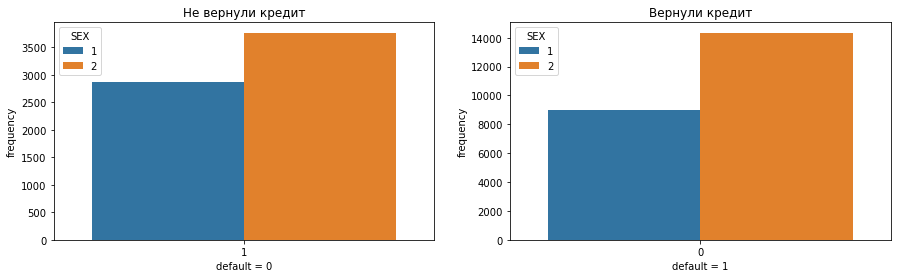

In [19]:
fig, axs = plt.subplots(1,2, figsize = (15,4))
sns.countplot(data = data_def, x ='default', hue = 'SEX', ax = axs[0])
sns.countplot(data = data_norm, x ='default', hue = 'SEX', ax = axs[1])
axs[0].set_title('Не вернули кредит')
axs[0].set_xlabel('default = 0')
axs[0].set_ylabel('frequency')
axs[1].set_title('Вернули кредит')
axs[1].set_ylabel('frequency')
axs[1].set_xlabel('default = 1')

Из графиков выше видно, женщины кредит берут чаще чем мужчины, кроме того, доля женщин в группе, где вернули кредит, больше чем  в группе, где кредит не вернули.

Интересно будет построить доверительный интервал для доли женщин в двух выборках

In [20]:
conf_interval_norm = proportion_confint(sum(data_norm.SEX == 2), 
                                            data_norm.shape[0],
                                            method = 'normal')
conf_interval_def = proportion_confint(sum(data_def.SEX == 2), 
                                            data_def.shape[0],
                                            method = 'normal')

In [21]:
print("Доверительный интервал для доли женщин в группе клиентов, которые вернули кредит = ",np.round(conf_interval_norm,2))

Доверительный интервал для доли женщин в группе клиентов, которые вернули кредит =  [0.61 0.62]


In [22]:
print("Доверительный интервал для доли женщин в группе клиентов, которые не вернули кредит = ",np.round(conf_interval_def,2))

Доверительный интервал для доли женщин в группе клиентов, которые не вернули кредит =  [0.56 0.58]


Видно, что 95 процентные доверительные интервали не пересекаются, следовательно доля жещин в двух группах статистически различаются

Для интереса, можно построить 95 процентный доверительный интервал для разности двух долей и посмотреть, 0 попадает в этот интервал или нет

**Нулевая гипотеза**: Разность долей женщин в двух группах равно нулю

**Альтернативная гипотеза**: Разность долей женщин в двух группах не равно нулю


In [23]:
# Функция, которая возвращает доверительный интервал для разности долей
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [24]:
# Функция, возвращающая Z статистику для разности долей
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [25]:
# Функция, возвращающая достигаемый уровень значимости
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [26]:
data_def_female = data[data['default'] == 1].SEX == 2
data_norm_female = data[data['default'] == 0].SEX == 2

In [27]:
print("95 процентный доверительный интервал для разности двух долей = ",np.round(proportions_diff_confint_ind(data_def_female, data_norm_female, alpha = 0.05),3) )

95 процентный доверительный интервал для разности двух долей =  [-0.061 -0.034]


Видно, что ноль туда не входит

In [28]:
# z - статистика для двух долей
print("z - статистика для разности двух долей= ", np.round(proportions_diff_z_stat_ind(data_def_female, data_norm_female),3))

z - статистика для разности двух долей=  -6.921


In [29]:
# Достигаемый уровень значимости для z статистики (двухсторонняя альтернатива)
print("Достигаемый уровень значимости = ", proportions_diff_z_test(proportions_diff_z_stat_ind(data_def_female, data_norm_female), alternative = 'two-sided'))

Достигаемый уровень значимости =  4.472866521609831e-12


**p_value почти ноль, это говорит о том, что нулевая гипотеза отвергается на любом адекватном уровне значимости**

##  <center> Образование 
**Проверим гипотезу следующую гипотезу: образование не влияет на то, вернет клиент долг или нет**

Посмотрим на распределение по образованию в двух группах 

Text(0.5, 1.0, 'default = 0')

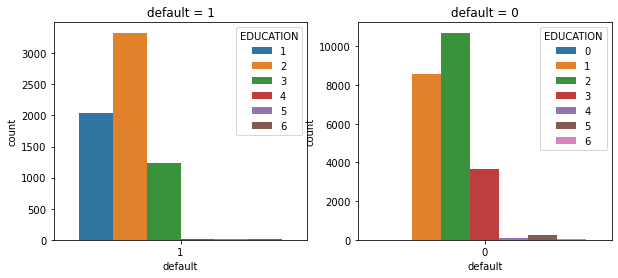

In [30]:
fig, axs = plt.subplots(1,2, figsize = (10,4))
sns.countplot(data = data_def, x = 'default', hue = 'EDUCATION', ax = axs[0],)
sns.countplot(data = data_norm, x = 'default', hue = 'EDUCATION', ax = axs[1])
axs[0].set_title('default = 1')
axs[1].set_title('default = 0')

Как видно из графиков, распределения немного отличаются, кроме этого, в группе клиентов не вернувших кредит, нет докторов наук, то есть все клиенты, которые имеют степень доктора, вернули кредит

Есть смысл посчитать соотношение количества людей которые вернули кредит к общей сумме клиентов, группировку следует провести по образованию

In [31]:
percent_educ = data\
    .groupby('EDUCATION')\
    .default\
    .value_counts(normalize = True)\
    .to_frame()\
    .rename(columns = {'default':'percent_actual'})\
    .reset_index()\
    .query("default == 0")\
    .drop('default', axis = 1)\
    .set_index('EDUCATION')

In [32]:
# Образование на возврат кредита (вероятность)
percent_educ

,percent_actual
EDUCATION,
0,1.000000
1,0.807652
2,0.762651
3,0.748424
4,0.943089
5,0.935714
6,0.843137


Как видно из таблицы, распределение неравномерно, следовательно образование играет большую роль в том, вернет кредит клиент или нет



Посчитаем общую долю тех, кто вернул кредит

In [33]:
data[data['default'] == 0].shape[0] / data.shape[0]

0.7788

Предположение о том, что образование не влияет на то, вернет клиент кредит или нет, говорит о следующем: вероятность вернуть кредить равна для всех значений фактора EDUCATION

In [34]:
percent_expect = percent_educ.percent_actual.mean()

In [35]:
percent_educ['percent_expect'] = percent_expect

In [36]:
percent_educ = percent_educ.apply(lambda x: np.round(x,3)).reset_index()

In [37]:
percent_educ

,EDUCATION,percent_actual,percent_expect
0,0,1.000,0.863
1,1,0.808,0.863
2,2,0.763,0.863
3,3,0.748,0.863
4,4,0.943,0.863
5,5,0.936,0.863
6,6,0.843,0.863


Добавим в таблицу количество клиентов, сгрупированных по образованию

In [38]:
clients_educ =data\
                .groupby('EDUCATION',as_index = False)\
                .agg({'default':'count'})\
                .rename(columns = {'default':'clients_numb'})

In [39]:
clients_educ

,EDUCATION,clients_numb
0,0,14
1,1,10585
2,2,14030
3,3,4917
4,4,123
5,5,280
6,6,51


In [40]:
table_expect_actual = percent_educ.merge(clients_educ, on = 'EDUCATION')

In [41]:

table_expect_actual

,EDUCATION,percent_actual,percent_expect,clients_numb
0,0,1.000,0.863,14
1,1,0.808,0.863,10585
2,2,0.763,0.863,14030
3,3,0.748,0.863,4917
4,4,0.943,0.863,123
5,5,0.936,0.863,280
6,6,0.843,0.863,51


Подсчитаем разницу между ожидаемыми клиентами, которые вернут кредит и фактическими

In [42]:
table_expect_actual['clients_expect'] = round(table_expect_actual['clients_numb']*table_expect_actual['percent_expect']).astype('int')
table_expect_actual['clients_actual'] = round(table_expect_actual['clients_numb']*table_expect_actual['percent_actual']).astype('int')

In [43]:
table_expect_actual['diff'] = table_expect_actual.clients_actual - table_expect_actual.clients_expect

In [44]:
table_expect_actual

,EDUCATION,percent_actual,percent_expect,clients_numb,clients_expect,clients_actual,diff
0,0,1.000,0.863,14,12,14,2
1,1,0.808,0.863,10585,9135,8553,-582
2,2,0.763,0.863,14030,12108,10705,-1403
3,3,0.748,0.863,4917,4243,3678,-565
4,4,0.943,0.863,123,106,116,10
5,5,0.936,0.863,280,242,262,20
6,6,0.843,0.863,51,44,43,-1


Как видно из таблицы разница далека от нуля

**Наличие образования Доктор является наилучшим индикатором того, что клиент вернет кредит!!**

## <center> Семейное положение
**Проверим, как связан семейный статус с индикатором дефолта**

Text(0.5, 1.0, 'default = 0')

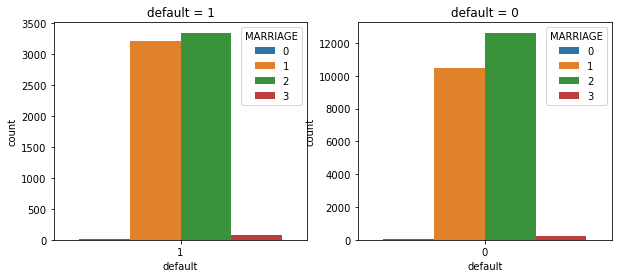

In [45]:
fig, axs = plt.subplots(1,2, figsize = (10,4))
sns.countplot(data = data_def, x = 'default', hue = 'MARRIAGE', ax = axs[0])
sns.countplot(data = data_norm, x = 'default', hue = 'MARRIAGE', ax = axs[1])
axs[0].set_title('default = 1')
axs[1].set_title('default = 0')

Можно использовать коэффициент крамера для анализа связи

In [46]:
def_0 = data\
            .groupby(['default','MARRIAGE'])\
            .agg({'ID':'count'})\
            .reset_index()\
            .query("default == 0")\
            .ID\
            .values

In [47]:
def_1 = data\
            .groupby(['default','MARRIAGE'])\
            .agg({'ID':'count'})\
            .reset_index()\
            .query("default == 1")\
            .ID\
            .values

In [48]:
matrix = np.concatenate(([def_0], [def_1]), axis = 0)

In [49]:
def cramers_corrected_stat(confusion_matrix):
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

Проверим нулевую гипотезу о том, что признак DEFAULT & MARRIAGE независимы

In [50]:
print("p_val = ", np.round(cramers_corrected_stat(matrix),2))

p_val =  0.03


**Гипотеза о том, что DEFAULT & MARRIAGE независимы, отвергается на 5 процентом уровне значимости**

## <center>Возраст
###  Относительно двух групп людей  вернувших и не вернувших кредит  проверим следующие гипотезы:
* О равенстве медианных значений возрастов людей   
* О равенстве распределений

**Проверить гипотезу о равенстве медианных значений возрастов людей**

In [51]:
age_def = data[data['default'] == 1].AGE.values
age_norm = data[data['default'] == 0].AGE.values

In [52]:
print( "Медиана AGE for def = 1, =", np.median(age_def), "\n")
print("Медиана AGE for def = 0, =", np.median(age_norm))

Медиана AGE for def = 1, = 34.0 

Медиана AGE for def = 0, = 34.0


Точечные оценки не отличаются, но однозначного вывода на данном этапе делать нельзя

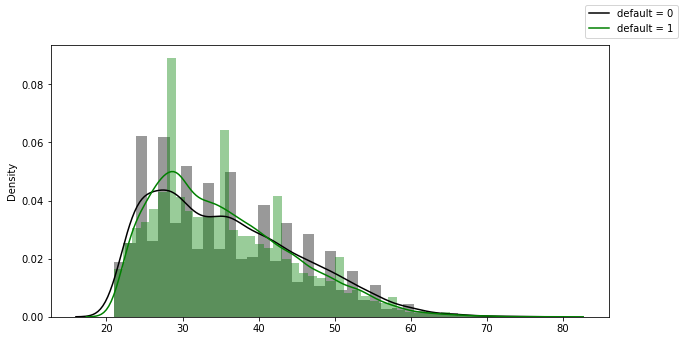

In [53]:
fig = plt.figure(1, figsize = (10,5))
sns.distplot(age_def, norm_hist = True, color = 'black')
sns.distplot(age_norm, norm_hist = True, color = 'green')
fig.legend(labels=['default = 0','default = 1'])

Как мы видим распределения возрастов по двум группам почти не отличаются

Нам неизвестны истинные распределения AGE для тех кто вернул / не вернул кредит. Следовательно можно использовать бустреп подход, сгенерируем 1000 выборок для обоих групп используя подход бутстреп и подсчитаем медиану

In [54]:
# медианы для сгенерированных выборок
age_def_medians = np.array(list(map(np.median,get_bootstrap_samples(age_def, 10000))))
age_norm_medians = np.array(list(map(np.median,get_bootstrap_samples(age_norm, 10000))))

In [55]:
# Сравним точечные оценки для медиан
print("Точечная оценка медианы для тех кто не вернул кредит = ",age_def_medians.mean())
print("Точечная оценка медианы для тех кто вернул кредит = ",age_norm_medians.mean())

Точечная оценка медианы для тех кто не вернул кредит =  34.1013
Точечная оценка медианы для тех кто вернул кредит =  33.9999


**Нулевая гипотеза**: Разница медиан равна нулю

**Альтернативная гипотеза**: Разница медиан не равна нулю

In [56]:
# 95 процентный доверительный интервал для разности медиан
boundaries = stat_intervals(age_def_medians - age_norm_medians, 0.05)
print(boundaries)

[0. 1.]


Как мы видим, интервал включает 0, соответственно медианные значения AGE для тех кто вернул и не вернул кредит статистически не различаются, нулевая гипотеза не отвергается на 5 процентном уровне значимости

**Проверка гипотезы о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних.**

Для того, чтобы проверить гипотезу о равенстве средних следует использовать перестановочный критерий для независимых выборок

**Нулевая гипотеза**: Распределение возраста для тех кто вернул кредит не отличается от распределения возраста для тех кто не вернул кредит

$F_{X_1}(x) = F_{X_2}(x)$

**Альтернативная гипотеза**: Распределения одинаковы при наличии сдвига у одного из распределений

$F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [60]:
print('p-value: %f' % permutation_test(age_def,age_norm, max_permutations=2000))

p-value: 0.012500


**p-value меньше 5 процентного уровня значимости, соответственно нулевая гипотеза о равенстве распределений отвергается**

## <center>Подведение итогов

В рамках данной работы были проанализированы следующие показатели по кредитным историям клиентов:
* **LIMIT_BALL** - Размер кредитного лимита
* **SEX** - Пол клиента
* **MARRIAGE** - Семейное положение
* **Возраст**

Результаты продемонстрировали, что первые три фактора влияют на возврат кредита, последний дал неоднозначные результаты, скорее всего возраст следовало бы разбить на возрастные группы и с каждым поработать отдельно. О степени влияния данных показателей на возрат говорить сложно, для такого анализа следует построить модель, которая прогнозируют вероятность возрата и посмореть на важность признаков.